# Levy Function Sensivity Analysis

## 1. Introduction

The present code evaluates the performance of the TuRBO algorithm in finding the minimum of the Levy function while varying:

- The number of trust regions (TR)
- The batch size
- The number of initial points per TR
- The dimensionality of the function

The performance will be evaluated as follows: three of this parameters will be kept constant, while one will be varied. The optimization process will be run on the function and the minimum value found will be recorded. Then, we will compare the values obtained for each value of the parameter. The maximum number of evaluations (`max_evals`) will be fixed at 1000. 

When not varied, the parameters will be fixed at:

- `n_trust_regions` = 5
- `batch_size` = 10
- `n_init` = 10
- `dim` = 10

### 1.1 About the function

## Levy Function

The **Levy function** is a standard non-convex benchmark function used to evaluate optimization algorithms.  
It is multimodal (has many local minima), which makes it challenging for global optimization methods.

The global minimum is located at:

$$ x_i = 1  \text{ for all } i $$

with function value:

$$f(x) = 0$$

### Definition

For a $d$-dimensional vector $x = (x_1, \dots, x_d)$, define:

$$w_i = 1 + \frac{x_i - 1}{4}$$

The Levy function is:

$$f(x) = \sin^2(\pi w_1) + \sum_{i=1}^{d-1} (w_i - 1)^2 \left[ 1 + 10 \sin^2(\pi w_i + 1) \right] + (w_d - 1)^2 \left[ 1 + \sin^2(2 \pi w_d) \right]$$

It is commonly evaluated over the domain:

$$x_i \in [-10, 10]$$

## 2. Pre-test codes

### 2.1 Imports

In [28]:
from turbo import TurboM 
from turbo import Turbo1
import numpy as np
import torch
import math
import matplotlib
import matplotlib.pyplot as plt

### 2.2 Levy Function Class

In [29]:
class Levy:
    def __init__(self, dim=10):
        self.dim = dim
        self.lb = -5 * np.ones(dim)
        self.ub = 10 * np.ones(dim)
        
    def __call__(self, x):
        assert len(x) == self.dim
        assert x.ndim == 1
        assert np.all(x <= self.ub) and np.all(x >= self.lb)
        w = 1 + (x - 1.0) / 4.0
        val = np.sin(np.pi * w[0]) ** 2 + \
            np.sum((w[1:self.dim - 1] - 1) ** 2 * (1 + 10 * np.sin(np.pi * w[1:self.dim - 1] + 1) ** 2)) + \
            (w[self.dim - 1] - 1) ** 2 * (1 + np.sin(2 * np.pi * w[self.dim - 1])**2)
        return val

f = Levy(10)

## 3. Varying `n_trust_regions`

In [ ]:
results_NTR = {
    "Turbo1": {},
    "TurboM": {}
}

### 3.1 One trust region (Turbo1)

In [ ]:
turbo1 = Turbo1(
    f=f,  
    lb=f.lb,  
    ub=f.ub,  
    n_init=20,  
    max_evals = 1000,  
    batch_size=10,  
    verbose=False,  
    use_ard=True,  
    max_cholesky_size=2000,  
    n_training_steps=50,  
    min_cuda=1024,  
    device="cpu",  
    dtype="float64",  
)

turbo1.optimize()

X = turbo1.X  # Evaluated points
fX = turbo1.fX  # Observed values
ind_best = np.argmin(fX)

results_NTR["Turbo1"][1] = {
    "minimum_x": X[ind_best, :],
    "minimum_fX": fX[ind_best].item()
}

Using dtype = torch.float64 
Using device = cpu
Starting from fbest = 14.0
70) New best: 12.46
80) New best: 10.03
90) New best: 8.059
100) New best: 7.954
120) New best: 7.224
130) New best: 6.67
150) New best: 6.601
160) New best: 6.553
170) New best: 6.472
190) New best: 6.445
200) New best: 6.362
220) New best: 6.331
230) New best: 6.328
230) Restarting with fbest = 6.328
Starting from fbest = 16.94
290) New best: 3.211
310) New best: 1.952
330) New best: 1.815
350) New best: 1.147
360) New best: 0.4023
380) New best: 0.308
390) New best: 0.2498
400) New best: 0.1379
440) New best: 0.1228
450) New best: 0.116
460) New best: 0.1051
480) Restarting with fbest = 0.1051
Starting from fbest = 24.71
770) Restarting with fbest = 0.5758
Starting from fbest = 26.15
950) Restarting with fbest = 8.695
Starting from fbest = 32.06


### 3.2 More trust regions (TurboM)

In [ ]:
n_trust_regions_list = [2, 3, 5, 10]

for NTR in n_trust_regions_list:

    turbo_m = TurboM(
        f=f,  
        lb=f.lb,  
        ub=f.ub,  
        n_init=10,  
        max_evals=1000, 
        n_trust_regions=NTR, # Varying 
        batch_size=10,  
        verbose=False,  
        use_ard=True,  
        max_cholesky_size=2000,  
        n_training_steps=50, 
        min_cuda=1024,  
        device="cpu", 
        dtype="float64",  
    )

    turbo_m.optimize()

    X = turbo_m.X  # Evaluated points
    fX = turbo_m.fX  # Observed values
    ind_best = np.argmin(fX)

    results_NTR["TurboM"][NTR] = {
        "minimum_x": X[ind_best, :],
        "minimum_fX": fX[ind_best].item()
    }

In [ ]:
minimum_fX_NTR = (
    [results_NTR["Turbo1"][1]["minimum_fX"]] +
    [results_NTR["TurboM"][n]["minimum_fX"] for n in results["TurboM"]]
)

In [34]:
print(minimum_fX_NTR)

[0.10514894176020785, 0.6827310885002523, 0.03703096443649106, 0.06195267615695969, 0.21650257560935113]


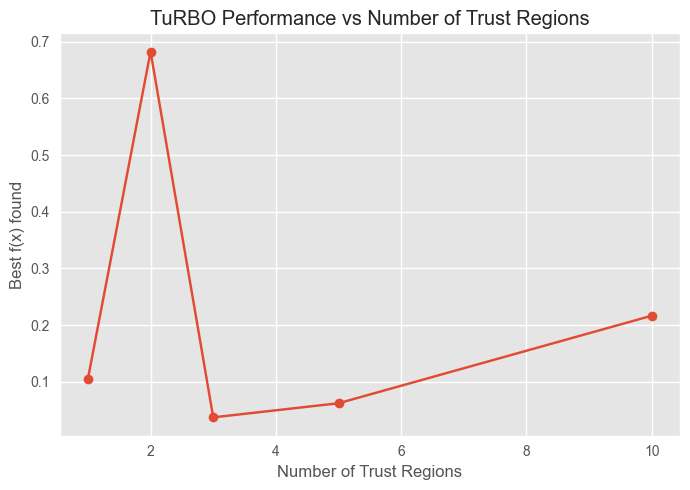

In [ ]:
n_trust_regions_list_final = [1] + n_trust_regions_list

plt.style.use("ggplot")

fig = plt.figure(figsize=(7, 5))
plt.plot(n_trust_regions_list_final, minimum_fX_NTR, marker = 'o')  
plt.xlabel("Number of Trust Regions")
plt.ylabel("Best f(x) found")
plt.title("TuRBO Performance vs Number of Trust Regions")

plt.grid(True)
plt.tight_layout()
plt.show()

## 4. Varying the `batch_size`

In [60]:
results_BS = {
    "TurboM": {}
}

In [ ]:
batch_size_list = [5, 10, 15, 20, 30, 50]

for BS in batch_size_list:

    turbo_m = TurboM(
        f=f,  
        lb=f.lb,  
        ub=f.ub,  
        n_init=10,  
        max_evals=1000, 
        n_trust_regions=5, 
        batch_size=BS,  # Varying
        verbose=False,  
        use_ard=True,  
        max_cholesky_size=2000,  
        n_training_steps=50, 
        min_cuda=1024,  
        device="cpu", 
        dtype="float64",  
    )

    turbo_m.optimize()

    X = turbo_m.X  # Evaluated points
    fX = turbo_m.fX  # Observed values
    ind_best = np.argmin(fX)

    results_BS["TurboM"][BS] = {
        "minimum_x": X[ind_best, :],
        "minimum_fX": fX[ind_best].item()
    }

In [64]:
minimum_fX_BS = [results_BS["TurboM"][n]["minimum_fX"] for n in results_BS["TurboM"]]

In [65]:
print(minimum_fX_BS)

[1.333867691316117, 1.8451020262178481, 0.1182903585298202, 0.14715285071693796, 1.3808912325458242]


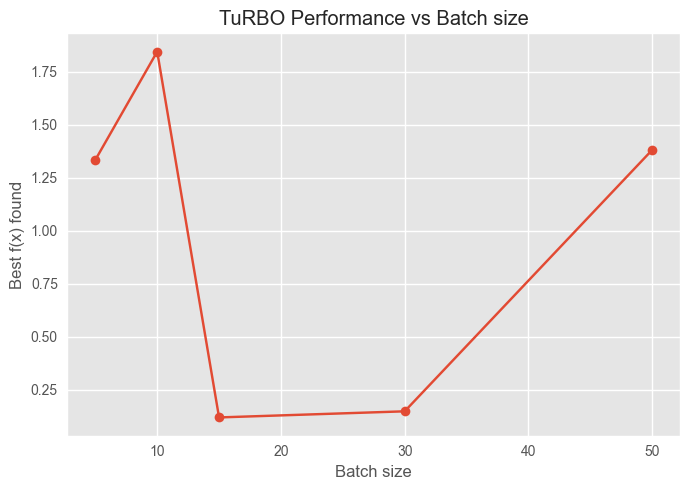

In [ ]:
plt.style.use("ggplot")

fig = plt.figure(figsize=(7, 5))
plt.plot(batch_size_list, minimum_fX_BS, marker = 'o')   
plt.xlabel("Batch size")
plt.ylabel("Best f(x) found")
plt.title("TuRBO Performance vs Batch size")

plt.grid(True)
plt.tight_layout()
plt.show()

## 4. Varying `n_init`

In [68]:
results_NI = {
    "TurboM": {}
}

In [69]:
n_init_list = [5, 10, 15, 20, 30, 50]

for NI in n_init_list:

    turbo_m = TurboM(
        f=f,  
        lb=f.lb,  
        ub=f.ub,  
        n_init=10,  
        max_evals=1000, 
        n_trust_regions=5, 
        batch_size=NI, # Varying 
        verbose=False,  
        use_ard=True,  
        max_cholesky_size=2000,  
        n_training_steps=50, 
        min_cuda=1024,  
        device="cpu", 
        dtype="float64",  
    )

    turbo_m.optimize()

    X = turbo_m.X  # Evaluated points
    fX = turbo_m.fX  # Observed values
    ind_best = np.argmin(fX)

    results_NI["TurboM"][NI] = {
        "minimum_x": X[ind_best, :],
        "minimum_fX": fX[ind_best].item()
    }

In [70]:
minimum_fX_NI = [results_NI["TurboM"][n]["minimum_fX"] for n in results_NI["TurboM"]]

In [71]:
print(minimum_fX_NI)

[0.04521331234167412, 0.11674829154797639, 0.47880163573472295, 1.7511594072688983, 0.6098106865373645, 0.47643051066251974]


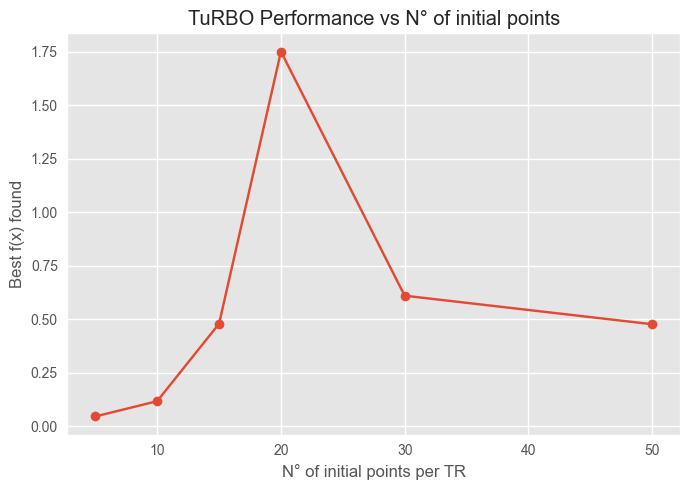

In [72]:
plt.style.use("ggplot")

fig = plt.figure(figsize=(7, 5))
plt.plot(n_init_list, minimum_fX_NI, marker = 'o')  
plt.xlabel("N° of initial points per TR")
plt.ylabel("Best f(x) found")
plt.title("TuRBO Performance vs N° of initial points")

plt.grid(True)
plt.tight_layout()
plt.show()

## 5. Varying dimensionality of the function

In [73]:
results_Dim = {
    "TurboM": {}
}

In [78]:
dimensionality_list = [2, 5, 10, 15, 20, 30]

for Dim in dimensionality_list:

    f = Levy(Dim) # Varying

    turbo_m = TurboM(
        f=f, # Here the dimensionality varies 
        lb=f.lb,  
        ub=f.ub,  
        n_init=10,  
        max_evals=1000, 
        n_trust_regions=5, 
        batch_size=10,
        verbose=False,  
        use_ard=True,  
        max_cholesky_size=2000,  
        n_training_steps=50, 
        min_cuda=1024,  
        device="cpu", 
        dtype="float64",  
    )

    turbo_m.optimize()

    X = turbo_m.X  # Evaluated points
    fX = turbo_m.fX  # Observed values
    ind_best = np.argmin(fX)

    results_Dim["TurboM"][Dim] = {
        "minimum_x": X[ind_best, :],
        "minimum_fX": fX[ind_best].item()
    }

In [79]:
minimum_fX_Dim = [results_Dim["TurboM"][n]["minimum_fX"] for n in results_Dim["TurboM"]]

In [80]:
print(minimum_fX_Dim)

[9.3329873932496e-06, 0.006729041005901044, 0.03473057258047139, 2.669187284725231, 0.6124985693053699, 0.9532576346710108]


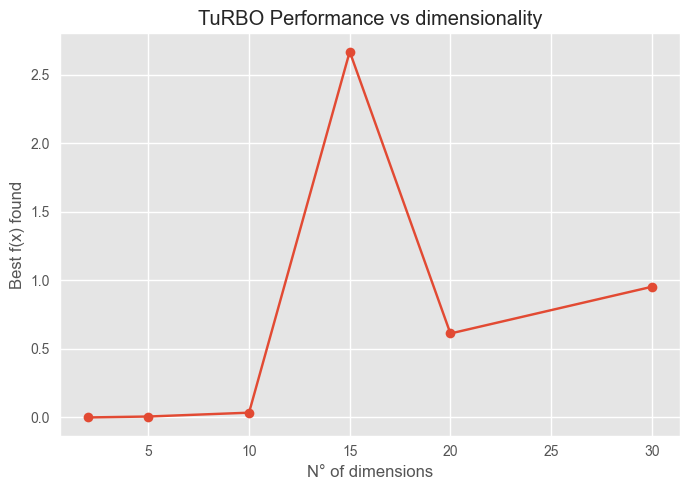

In [81]:
plt.style.use("ggplot")

fig = plt.figure(figsize=(7, 5))
plt.plot(dimensionality_list, minimum_fX_Dim, marker = 'o')  
plt.xlabel("N° of dimensions")
plt.ylabel("Best f(x) found")
plt.title("TuRBO Performance vs dimensionality")

plt.grid(True)
plt.tight_layout()
plt.show()